In [51]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from IPython.display import clear_output
import time
import seaborn as sns
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [43]:
from datasets import load_dataset

ds = load_dataset("ashraq/tmdb-celeb-10k",split='train')
ds = ds.select(range(1000))

In [44]:
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([ transforms.Resize((256,256)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.5],[0.5]),
])

def transforms(examples):
    examples["pixel_values"] = [transform(image.convert("RGB")) for image in examples["image"]]
    return examples

ds = ds.with_transform(transforms)

In [48]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    images = []
    labels = []
    for example in examples:
        images.append((example["pixel_values"]))
        
    pixel_values = torch.stack(images)
    return {"pixel_values": pixel_values}
dataloader = DataLoader(ds, collate_fn=collate_fn, batch_size=4)

In [59]:
for batch in dataloader:
    print(batch["pixel_values"].shape)
    plt.imshow(torchvision.utils.make_grid(batch["pixel_values"]*0.5 + 0.5).permute(1,2,0).cpu().numpy())
    clear_output(wait=True)
    plt.show()


KeyboardInterrupt: 

# Use the Diffuser Library

In [60]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
print(scheduler)

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.36.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}



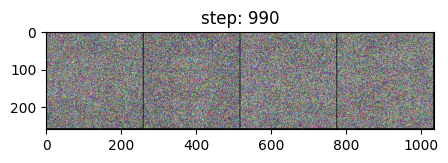

In [61]:
x = batch["pixel_values"]

for t in range(scheduler.num_train_timesteps):
    noise = torch.randn_like(x)
    
    x_noised = scheduler.add_noise(x, noise, torch.tensor(t).long())
    
    if t%10==0:
        plt.figure(figsize=(5,5))
        plt.title(f'step: {t}')
        plt.imshow(torchvision.utils.make_grid(x_noised*0.5 + 0.5).permute(1,2,0).cpu().numpy())
        clear_output(wait=True)
        plt.show()

# The Unet from the Diffusers Library

In [92]:
from diffusers import UNet2DModel

unet = UNet2DModel(
    sample_size=256,
    in_channels = 3,
    out_channels = 3,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    down_block_types = ('DownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D', 'AttnDownBlock2D'),
    mid_block_type = 'UNetMidBlock2D',
    up_block_types = ('AttnUpBlock2D', 'AttnUpBlock2D', 'AttnUpBlock2D', 'UpBlock2D'),
    block_out_channels= (64, 128, 160, 224),
)

In [93]:
# count num of parameters in the model
print(f'Number of parameters in the model: {sum(p.numel() for p in unet.parameters())}')

Number of parameters in the model: 17641699


In [95]:
unet.to(device)
x=torch.randn(5,3,256,256).to(device)
t = torch.linspace(0,999,5).long().to(device)

with torch.no_grad():
    output = unet(x,t)

In [96]:
def generate_image():
    xt = torch.randn(10,3,256,256).to(device)

    unet.eval()

    for t in tqdm(scheduler.timesteps,total=scheduler.num_train_timesteps,leave=False):
        with torch.no_grad():
            noise_pred = unet(xt,t).sample
            
        
        xt = scheduler.step(noise_pred, t, xt).prev_sample
        
    plt.figure(figsize=(10,3))
    plt.imshow(torchvision.utils.make_grid(xt*0.5 + 0.5).permute(1,2,0).cpu().numpy())
    plt.show()

In [97]:
generate_image()

/home/mohan.dash/miniconda3/envs/buawei/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Train the diffusion Model

  0%|          | 0/938 [00:00<?, ?it/s]

/home/mohan.dash/miniconda3/envs/buawei/lib/python3.10/site-packages/diffusers/configuration_utils.py:141: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/1000 [00:00<?, ?it/s]

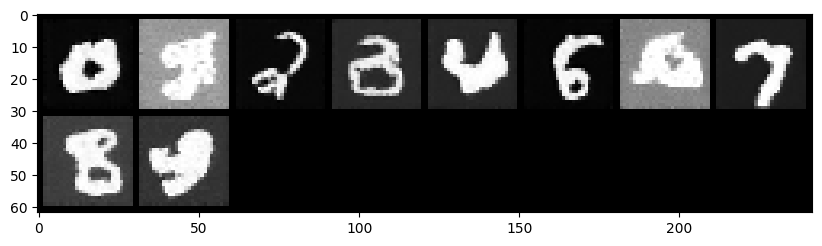

Finished epoch 0. Average of the last 100 loss values: 0.034718


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

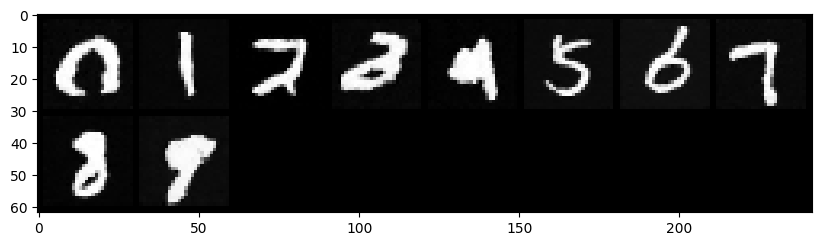

Finished epoch 1. Average of the last 100 loss values: 0.031549


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

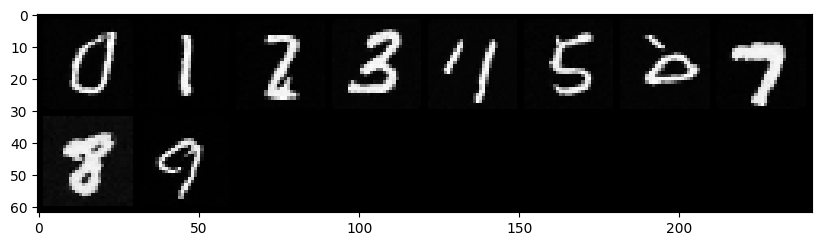

Finished epoch 2. Average of the last 100 loss values: 0.030151


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

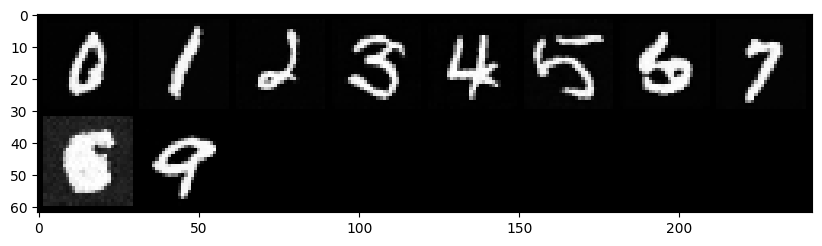

Finished epoch 3. Average of the last 100 loss values: 0.029003


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

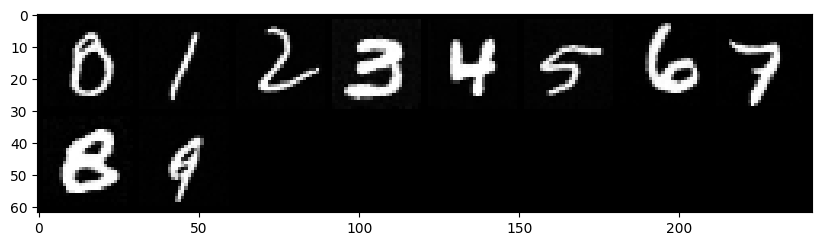

Finished epoch 4. Average of the last 100 loss values: 0.028404


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

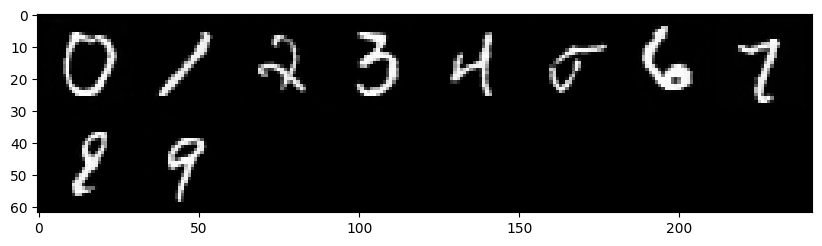

Finished epoch 5. Average of the last 100 loss values: 0.028259


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

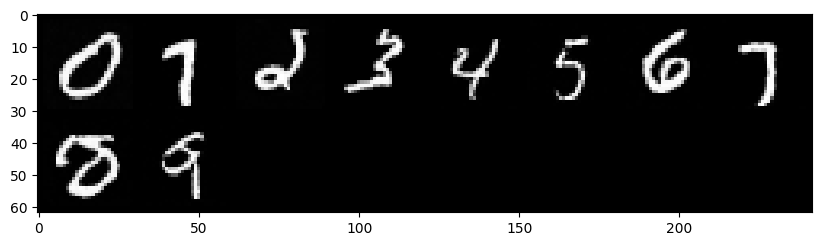

Finished epoch 6. Average of the last 100 loss values: 0.028041


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

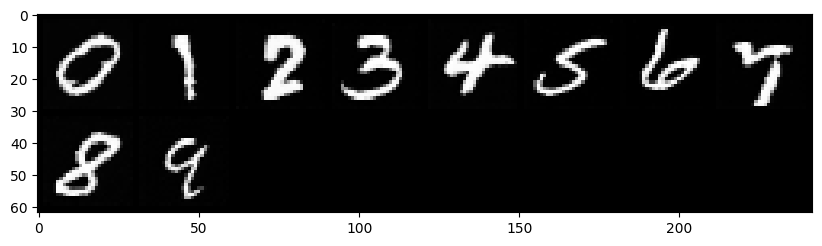

Finished epoch 7. Average of the last 100 loss values: 0.028125


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

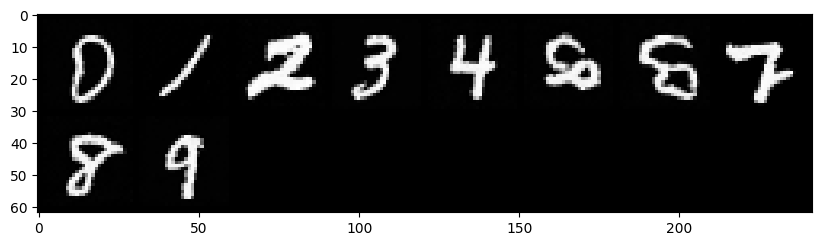

Finished epoch 8. Average of the last 100 loss values: 0.027344


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

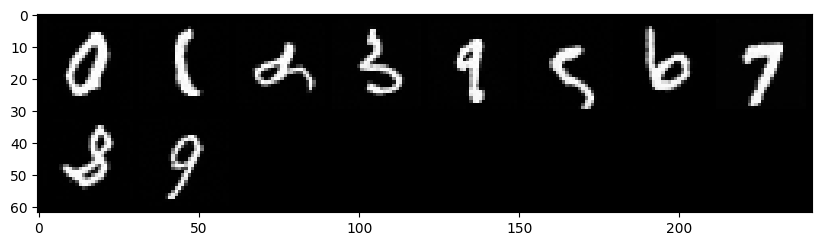

Finished epoch 9. Average of the last 100 loss values: 0.027281


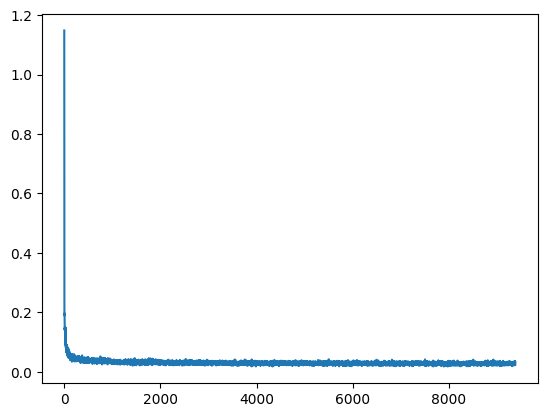

In [42]:

# How many runs through the data should we do?
n_epochs = 10

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.AdamW(unet.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader,total=len(train_dataloader),leave=False):
        
        # Get some data and prepare the corrupted version
        x = x.to(device) 
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = unet(noisy_x, timesteps, y).sample # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())
        
    generate_image()

    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
        

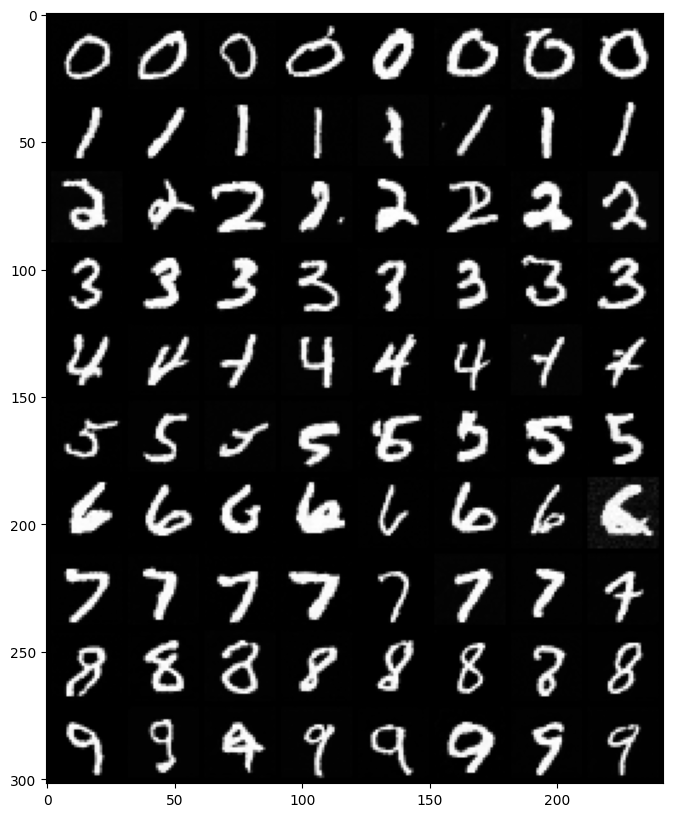

In [44]:
# xt = torch.randn(80,1,28,28).to(device)
# y =  torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

# unet.eval()

# for t in tqdm(scheduler.timesteps,total=scheduler.num_train_timesteps,leave=False):
#     with torch.no_grad():
#         noise_pred = unet(xt,t,y).sample
        
    
#     xt = scheduler.step(noise_pred, t, xt).prev_sample
    
plt.figure(figsize=(10,10))
plt.imshow(torchvision.utils.make_grid(xt*0.5 + 0.5).permute(1,2,0).cpu().numpy())
plt.show()